In [3]:
import os
import numpy as np
from PIL import Image, ImageFile
from skimage import io
import matplotlib.pyplot as plt
import tifffile
from scipy import misc
from tifffile import TiffFile
from tifffile.tifffile import TIFF_DECOMPESSORS
from visualization import ids_to_greyscale, load_depth, show_bounding_boxes, load_stencil_ids, load_stencil_flags, \
get_bounding_boxes, show_loaded_bounding_boxes, get_detections

In [7]:
import visualization
visualization.multi_page = False
visualization.ini_file = 'gta-postprocessing.local.ini'

scene_condition = """
    ( \
        SELECT scene_id \
        FROM snapshots \
        WHERE run_id = 6 \
        ORDER BY timestamp DESC \
        OFFSET 80 \
        LIMIT 1 \
    ) \
    """

scene_condition = """
    '1ca7f4b8-ef30-4a9f-8657-bc977dd04a89' \
    """

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, cam_near_clip, cam_far_clip, timestamp, view_matrix, proj_matrix, world_matrix, 
    width, height, \
    ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as relative_cam_rot \
    FROM snapshots \
    WHERE scene_id = {} \
    ORDER BY snapshot_id ASC \
    """.format(scene_condition))

results = [dict(res) for res in cur]
for i, res in enumerate(results):
    res['view_matrix'] = np.array(res['view_matrix'])
    res['proj_matrix'] = np.array(res['proj_matrix'])
    res['world_matrix'] = np.array(res['world_matrix'])
    results[i] = res

names = [i['imagepath'] for i in results]
print(names[0])

2018-02-22--20-09-16--402


### obtaining detections for this scene

In [8]:
detections = {}
for res in results:
    cur.execute("""SELECT detection_id, type, class, bbox, \
        snapshot_id, handle, ARRAY[st_x(pos), st_y(pos), st_z(pos)] AS pos \
        FROM detections \
        WHERE snapshot_id = {} \
        AND type = 'car' \
        AND NOT bbox @> point '(Infinity, Infinity)' \
        """.format(res['snapshot_id']))
    detections[res['snapshot_id']] = [dict(i) for i in cur]


In [9]:
for res in results:  
    print('detections for image {}:'.format(res['snapshot_id']))
    for det in detections[res['snapshot_id']]:
        print(det)

detections for image 6205:
{'bbox': '(0.51375937461853,0.407715231180191),(0.504199624061584,0.397006869316101)', 'detection_id': 1016630, 'handle': 48642, 'pos': [-835.543640136719, 116.264846801758, 55.1736297607422], 'type': 'car', 'snapshot_id': 6205, 'class': 'SUVs'}
{'bbox': '(0.583395004272461,0.413993269205093),(0.561316549777985,0.397090435028076)', 'detection_id': 1016631, 'handle': 51714, 'pos': [-791.030456542969, 48.6587524414062, 49.0399360656738], 'type': 'car', 'snapshot_id': 6205, 'class': 'SUVs'}
{'bbox': '(0.750820457935333,0.388941287994385),(0.740167677402496,0.372951626777649)', 'detection_id': 1016632, 'handle': 74498, 'pos': [-751.287963867188, 85.3944091796875, 55.260871887207], 'type': 'car', 'snapshot_id': 6205, 'class': 'SUVs'}
{'bbox': '(0.791262686252594,0.385664820671082),(0.781465172767639,0.375156730413437)', 'detection_id': 1016633, 'handle': 74754, 'pos': [-741.572326660156, 70.5293197631836, 53.8663024902344], 'type': 'car', 'snapshot_id': 6205, 'cla

### showing rgb images

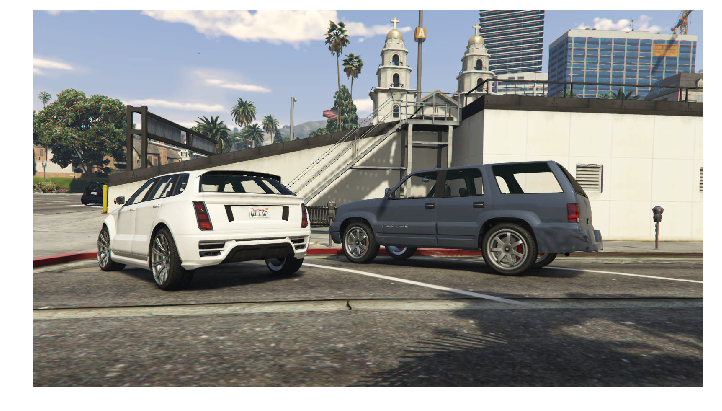

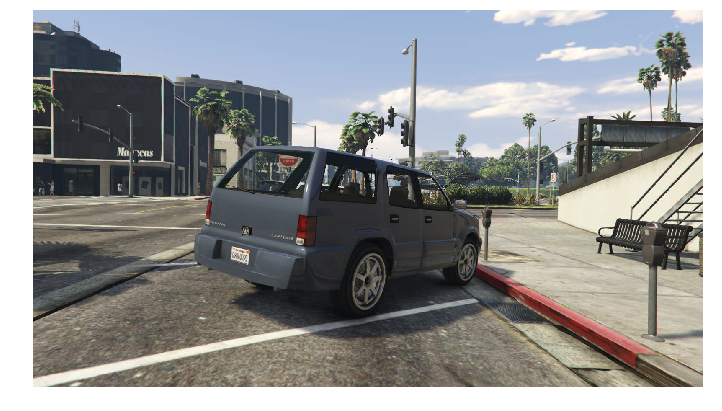

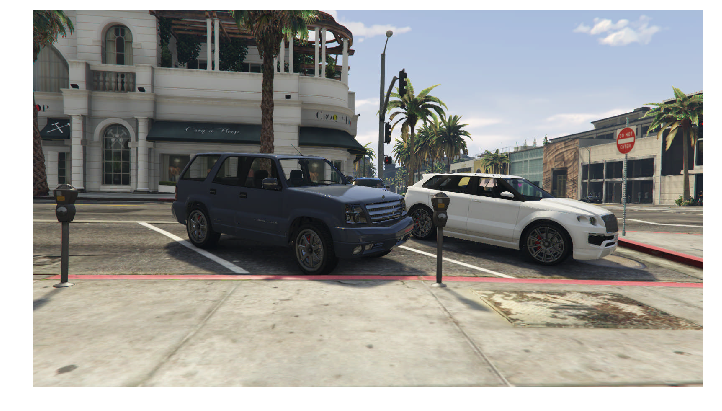

In [10]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    plt.show()

### showing depths

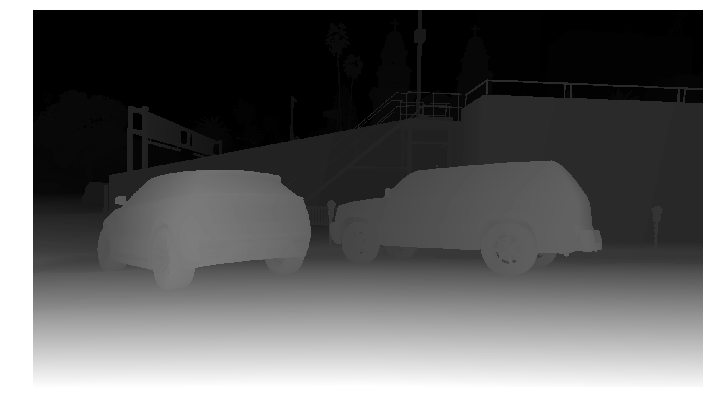

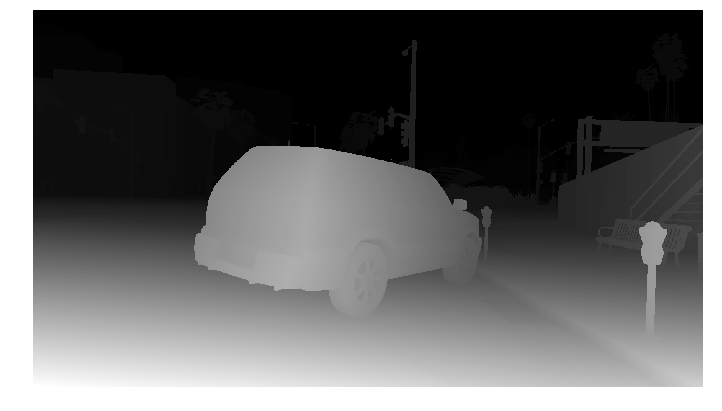

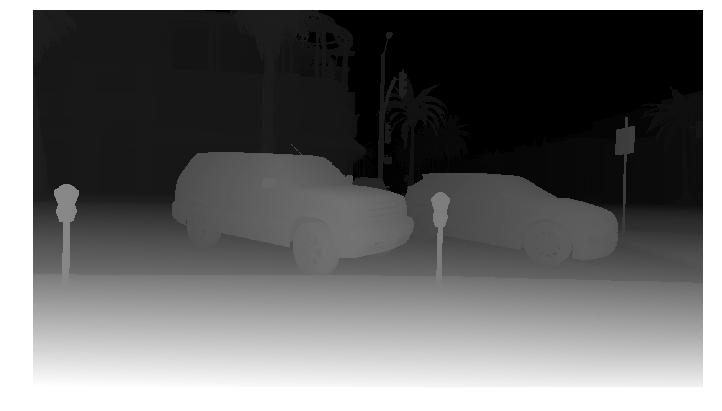

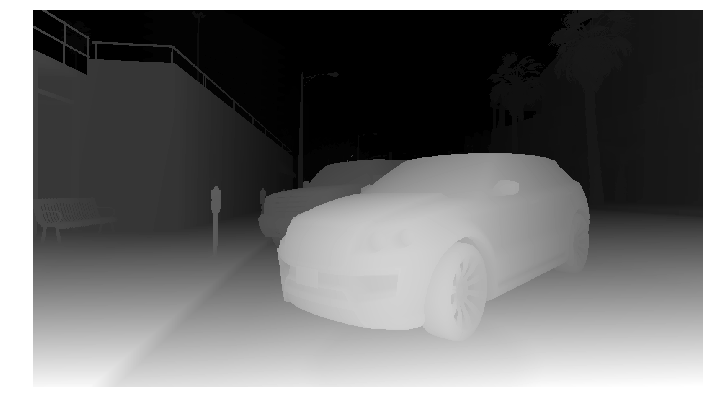

In [11]:
for name in names:
    depth = load_depth(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### showing stencil ids

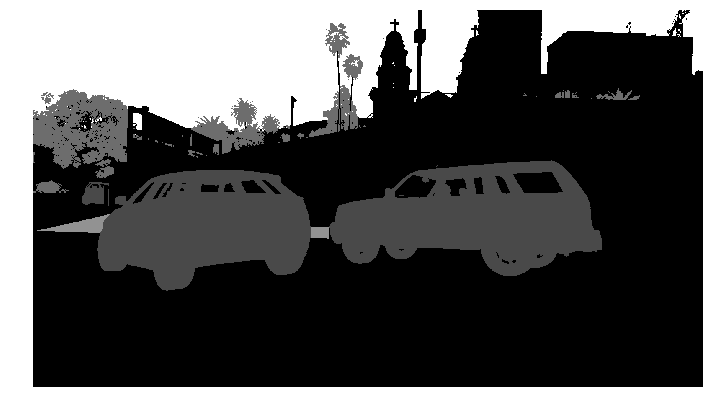

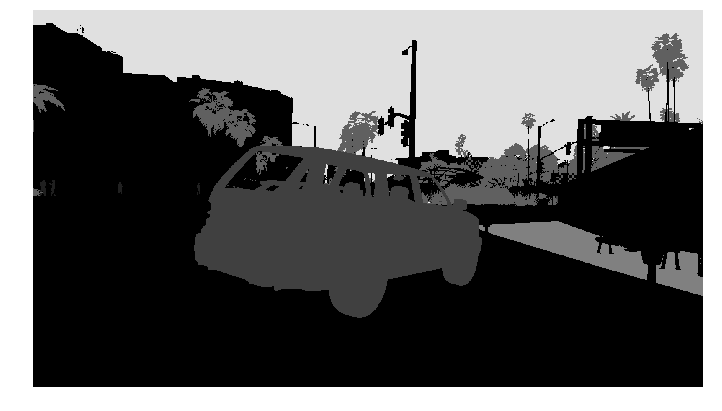

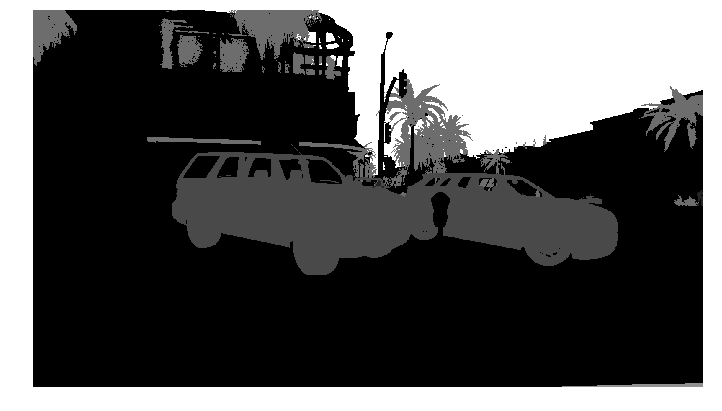

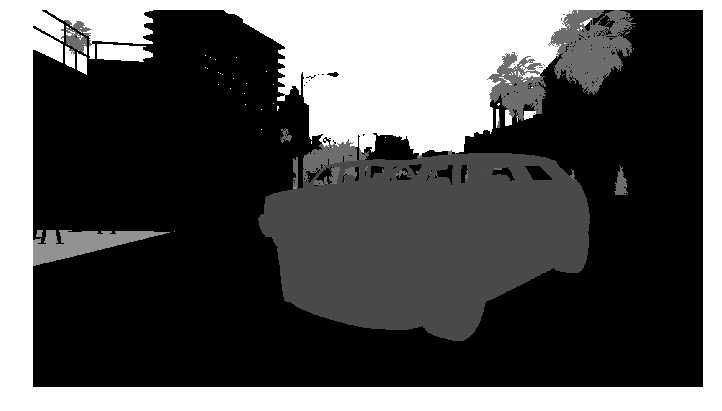

In [12]:
for name in names:
    depth = load_stencil_ids(name)
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(depth, cmap='gray')
    plt.show()


### tinkering with depth, showing its values

Depth is in NDC, openGL's Normalized Device Coordinates. 

According to [this thread](https://www.opengl.org/discussion_boards/showthread.php/170718-Normalized-Device-Coordinates) 
it maps from $[near clip (n_c), far clip(f_c)]$ to $[-1, 1]$.

So the formula for calculating NDC from world coordinates (WC) is simple linear transformation:

$ NDC = k \cdot WC + q $

$ -1 = k \cdot n_c + q $

$ 1 = k \cdot f_c + q $

After solving these equations, we obtain transformation parameters

$ q = -1 - k \cdot n_c $

$ q = 1 - k \cdot f_c $

$ -1 - k \cdot n_c = 1 - k \cdot f_c $

$ - k \cdot n_c = 2 - k \cdot f_c $

$ -2 = k (n_c - f_c) $

$ k = \frac{-2}{n_c - f_c} $

$ q = 1 - k \cdot f_c $

$ q = 1 - \frac{-2}{n_c - f_c} \cdot f_c $

$ q = 1 + \frac{2 f_c}{n_c - f_c} $

So the resulting linear transformations is as follows

$ NDC = \frac{-2}{n_c - f_c} \cdot WC + \frac{2 f_c}{n_c - f_c} $

And the reverse transformation, from NDC back to WC, shall be obtained by the same approach

$ WC = k \cdot NDC + q $

$ n_c = k \cdot -1 + q $

$ f_c = k \cdot 1 + q $

$ n_c = -k + q $

$ f_c = k + q $

After solving these equations, we obtain transformation parameters

$ q = n_c + k $

$ q = f_c - k $

$ n_c + k = f_c - k $

$ n_c + 2k = f_c $

$ k = \frac{f_c - n_c}{2} $

$ q = f_c - k $

$ q = f_c - \frac{f_c - n_c}{2} $

$ q = f_c + \frac{-f_c + n_c}{2} $

$ q = \frac{f_c + n_c}{2} $

And resulting transformation is

$ WC = \frac{f_c - n_c}{2} \cdot NDC + \frac{f_c + n_c}{2} $



For mapping from and to $[0, 1]$

So the formula for calculating NDC from world coordinates (WC) is simple linear transformation:

$ NDC = k \cdot WC + q $

$ 0 = k \cdot n_c + q $

$ 1 = k \cdot f_c + q $

After solving these equations, we obtain transformation parameters

$ q = 0 - k \cdot n_c $

$ q = 1 - k \cdot f_c $

$ 0 - k \cdot n_c = 1 - k \cdot f_c $

$ - k \cdot n_c = 1 - k \cdot f_c $

$ -1 = k (n_c - f_c) $

$ k = \frac{-1}{n_c - f_c} $

$ q = - k \cdot f_c $

$ q = - \frac{-1}{n_c - f_c} \cdot f_c $

$ q = \frac{f_c}{n_c - f_c} $

So the resulting linear transformations is as follows

$ NDC = \frac{-1}{n_c - f_c} \cdot WC + \frac{f_c}{n_c - f_c} $

And the reverse transformation, from NDC back to WC, shall be obtained by the same approach

$ WC = k \cdot NDC + q $

$ n_c = k \cdot 0 + q $

$ f_c = k \cdot 1 + q $

$ n_c = q $

$ f_c = k + q $

After solving these equations, we obtain transformation parameters

$ q = n_c $

$ q = f_c - k $

$ n_c = f_c - k $

$ n_c + k = f_c $

$ k = f_c - n_c $

$ q = f_c - k $

$ q = f_c - (f_c - n_c) $

$ q = n_c $

And resulting transformation is

$ WC = (f_c - n_c) \cdot NDC + n_c $


In [13]:
for res in results:    
    name = res['imagepath']
    depth = load_depth(name)
    near_clip = res['cam_near_clip']
    far_clip = res['cam_far_clip']
    print('camera rot: {}'.format(res['relative_cam_rot']))
    print('image name: {}'.format(res['imagepath']))
    print('created: {}'.format(res['timestamp']))
    print('depth min: {}'.format(np.min(depth)))
    print('depth max: {}'.format(np.max(depth)))
    print('near clip: {}'.format(near_clip))
    print('far clip: {}'.format(far_clip))
    
    k = (far_clip - near_clip) / 2
    q = (far_clip + near_clip) / 2
    new_depth = depth * k + q
    print('new depth min: {}'.format(np.min(new_depth)))
    print('new depth max: {}'.format(np.max(new_depth)))
    
    # fig = plt.figure(figsize=(12,12))
    # plt.axis('off')
    # plt.imshow(new_depth, cmap='gray')
    # plt.show()


camera rot: [0.0, 0.0, 0.0]
image name: 2018-02-22--20-09-16--402
created: 2018-02-22 20:09:16.402457+00:00
depth min: 0.0
depth max: 0.6439142227172852
near clip: 1.5
far clip: 800.0
new depth min: 400.75
new depth max: 657.832763671875
camera rot: [0.0, 0.0, 90.0]
image name: 2018-02-22--20-09-17--291
created: 2018-02-22 20:09:17.291728+00:00
depth min: 0.0
depth max: 0.579456090927124
near clip: 1.5
far clip: 800.0
new depth min: 400.75
new depth max: 632.0978393554688
camera rot: [0.0, 0.0, 180.0]
image name: 2018-02-22--20-09-18--205
created: 2018-02-22 20:09:18.205218+00:00
depth min: 0.0
depth max: 0.5752445459365845
near clip: 1.5
far clip: 800.0
new depth min: 400.75
new depth max: 630.4163818359375
camera rot: [0.0, 0.0, 270.0]
image name: 2018-02-22--20-09-19--185
created: 2018-02-22 20:09:19.185893+00:00
depth min: 0.0
depth max: 0.6007925868034363
near clip: 1.5
far clip: 800.0
new depth min: 400.75
new depth max: 640.616455078125


### showing bounding boxes

In [14]:
name = names[3]
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
size = (im.size[1], im.size[0])
show_bounding_boxes(name, size, plt.gca())


### showing bounding boxes for all cameras

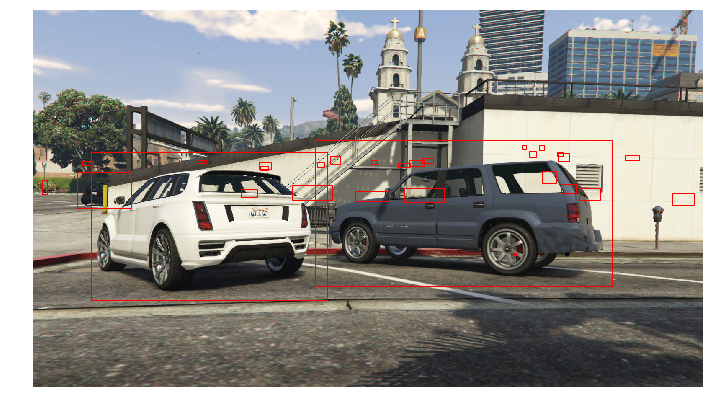

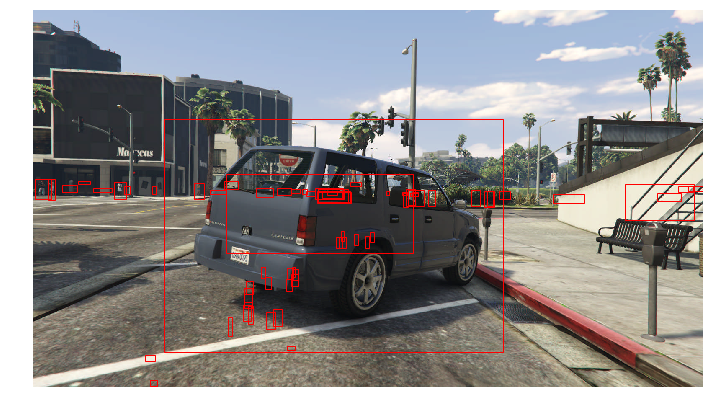

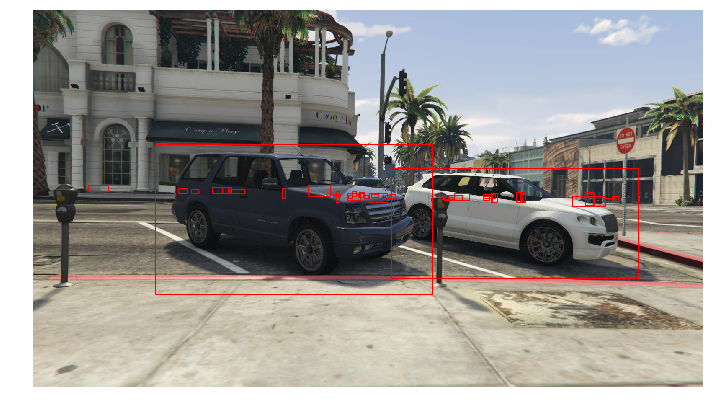

In [15]:
for name in names:
    im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
    fig = plt.figure(figsize=(12,12))
    plt.axis('off')
    plt.imshow(im)
    size = (im.size[1], im.size[0])
    show_bounding_boxes(name, size, plt.gca())


pos: [-750.9630127   -90.27867126   37.23519135], type: car, class: SUVs, handle: 53250
pos: [-754.61206055  -93.23101807   36.78868103], type: car, class: SUVs, handle: 52994


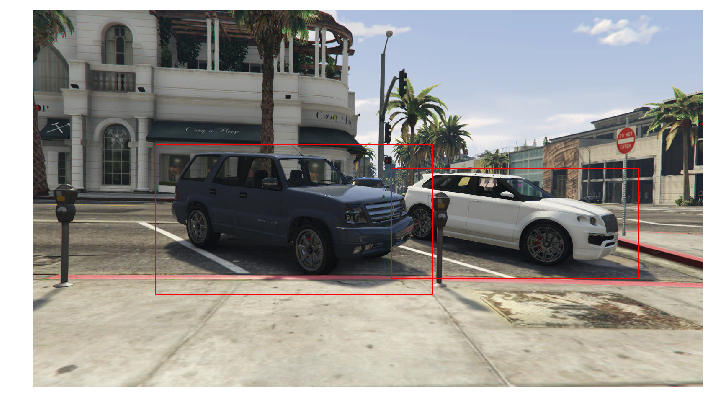

In [19]:
name = names[2]
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
size = (im.size[1], im.size[0])
detections = get_bounding_boxes(name)
detections = [d for d in detections if (d['bbox'][0, 0] - d['bbox'][1, 0]) > 0.2]
show_loaded_bounding_boxes(detections, size, plt.gca())
for det in detections:
    print('pos: {}, type: {}, class: {}, handle: {}'.format(det['pos'], det['type'], det['class'], det['handle']))

In [19]:
print('columns: '+', '.join(detections[0].keys()))
for det in detections:
    bbox = det['bbox']
    print(bbox)
    print(det['bbox'][0, 0] - det['bbox'][1, 0])
    print(det['pos'])

detections = get_detections(name)
# car 0 je to černé
car_0 = [d for d in detections if d['handle'] == 53250][0]
# car 1 je to bílé
car_1 = [d for d in detections if d['handle'] == 52994][0]

print('car_0 pos: '+ str(car_0['pos']))
print('car_1 pos: '+ str(car_1['pos']))
print('cars distance: '+ str(np.linalg.norm(car_0['pos'][0:2] - car_1['pos'][0:2])))


columns: bbox, type, handle, pos, bbox3d, proj_matrix, world_matrix, view_matrix, class
[[ 0.59606338  0.75226778]
 [ 0.18171251  0.35561895]]
0.414350867271
[-750.9630127   -90.27867126   37.23519135]
[[ 0.90310097  0.71120816]
 [ 0.53367311  0.41787088]]
0.369427859783
[-754.61206055  -93.23101807   36.78868103]


car_0 pos: [-750.9630127   -90.27867126   37.23519135]
car_1 pos: [-754.61206055  -93.23101807   36.78868103]
cars distance: 4.69381527767


### playing with depth and bounding boxes

detections before filtering: 28
detections after filtering: 1


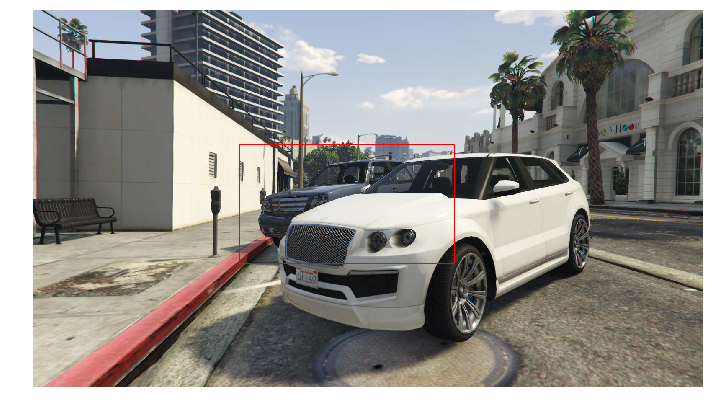

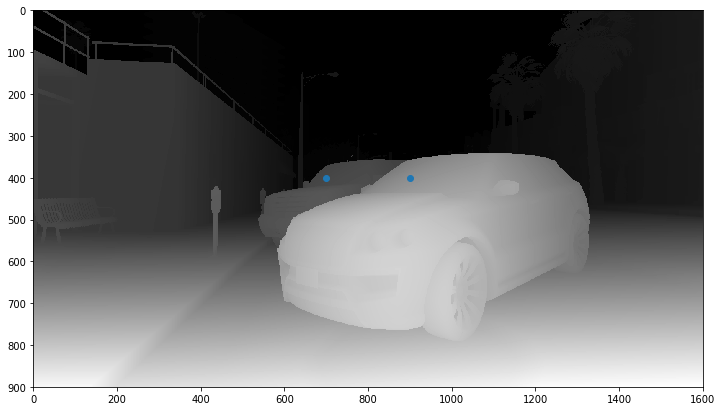

In [20]:
name = names[3]
im = Image.open(os.path.join(visualization.get_in_directory(), name + '.tiff'))
fig = plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(im)
size = (im.size[1], im.size[0])
detections = get_bounding_boxes(name)
print('detections before filtering: ' + str(len(detections)))
# sizes = [str(d['bbox'][0, 0] - d['bbox'][1, 0]) for d in detections]
# print('sizes: '+', '.join(sizes))
orig_detections = detections
detections = [d for d in detections if (d['bbox'][0, 0] - d['bbox'][1, 0]) > 0.2]
show_loaded_bounding_boxes(detections, size, plt.gca())
print('detections after filtering: ' + str(len(detections)))

depth = load_depth(name)
fig = plt.figure(figsize=(12,12))
plt.axis('on')
# plt.gca().grid(color='r', linestyle='-', linewidth=1)
point_0 = (400, 700)
point_1 = (400, 900)
plt.plot([point_0[1], point_1[1]], [point_0[0], point_1[0]], 'o')
plt.imshow(depth, cmap='gray')
plt.show()

In [21]:
print('raw point 0: {}'.format(depth[point_0]))
print('raw point 1: {}'.format(depth[point_1]))
print('raw depth distance: '+ str(depth[point_1] - depth[point_0]))

k = (far_clip - near_clip) / 2
q = (far_clip + near_clip) / 2
new_depth = depth * k + q
print('-1,1 depth distance: {}'.format(new_depth[point_1] - new_depth[point_0]))

k = far_clip - near_clip
q = near_clip
new_depth = depth * k + q
print('0, 1 point 0: {}'.format(new_depth[point_0]))
print('0, 1 point 1: {}'.format(new_depth[point_1]))
print('0, 1 depth distance: {}'.format(new_depth[point_1] - new_depth[point_0]))

c = 1
new_depth = (np.exp(depth * np.log(far_clip * c + 1)) - 1)/c
print('exp depth distance: {}'.format(new_depth[point_1] - new_depth[point_0]))
new_depth = 1 / new_depth
print('exp invered point 0: {}'.format(new_depth[point_0]))
print('exp invered point 1: {}'.format(new_depth[point_1]))
print('exp invered depth distance: {}'.format(new_depth[point_1] - new_depth[point_0]))

res = results[3]
print('keys: '+', '.join(res.keys()))
print('view matrix:')
print(np.array(res['view_matrix']))
print('proj matrix:')
print(np.array(res['proj_matrix']))


raw point 0: 0.16537852585315704
raw point 1: 0.3340008556842804
raw depth distance: 0.168622
-1,1 depth distance: 67.32247924804688
0, 1 point 0: 133.55474853515625
0, 1 point 1: 268.1996765136719
0, 1 depth distance: 134.64492797851562
exp depth distance: 6.307251453399658
exp invered point 0: 0.49472323060035706
exp invered point 1: 0.12006843090057373
exp invered depth distance: -0.3746547996997833
keys: relative_cam_rot, height, cam_far_clip, cam_near_clip, view_matrix, width, proj_matrix, timestamp, world_matrix, snapshot_id, imagepath
view matrix:
[[  3.85129740e-01  -9.22652783e-01   1.96705051e-02   2.05009416e+02]
 [  6.74176793e-03   2.41269392e-02   9.99686182e-01  -3.01840144e+01]
 [ -9.22837882e-01  -3.84876309e-01   1.55123118e-02  -7.37906068e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
proj matrix:
[[  1.20628515e+00   1.72616702e-10   3.67236210e-09  -4.02495006e-06]
 [ -1.67771935e-09   2.14450686e+00  -1.55282063e-09  -2.60508820e-07]

c:\users\azathoth\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
depth[899, 800]

In [23]:
depth[100, 1400]

0.046384342

In [24]:
print(np.min(depth))
print(np.max(depth))

0.0
0.600793


In [25]:
print(np.min(new_depth))
print(np.max(new_depth))
print(depth.shape)

0.0183405
inf
(900, 1600)


In [26]:
 vec = (700/depth.shape[1], 500/depth.shape[0], depth[500, 700])

In [27]:
submatrix = res['view_matrix'][0:3, 0:3]
print(submatrix)
np.linalg.det(submatrix)


[[ 0.38512974 -0.92265278  0.01967051]
 [ 0.00674177  0.02412694  0.99968618]
 [-0.92283788 -0.38487631  0.01551231]]


1.0000000939886335

In [28]:
proj_matrix = res['proj_matrix']
vec = np.linalg.inv(proj_matrix) @ np.array([[1], [1], [0.002], [1]])
print(vec / vec[3])
print(res['cam_near_clip'])
print(res['cam_far_clip'])

print('proj_matrix')
print(proj_matrix)
print('inverted proj_matrix')
print(np.linalg.inv(proj_matrix))

print('rounding small values to zero')
proj_matrix[np.abs(proj_matrix) < 1e-7] = 0

print('proj_matrix')
print(proj_matrix)
print('inverted proj_matrix')
print(np.linalg.inv(proj_matrix))


el1 = (- far_clip - near_clip)/(2*(near_clip*far_clip))
el2 = (far_clip + near_clip)/(2*(near_clip*far_clip))
print(el1)
print(el2)

matrix = np.zeros((4, 4))
matrix[2, 3] = -1
matrix[3, 2] = el1
matrix[3, 3] = el2
print(matrix)
vec = matrix @ np.array([[1], [1], [0], [1]])
print(vec / vec[3])
print(proj_matrix[0,0])
print(1/ np.linalg.inv(proj_matrix)[0,0])


[[ 578.46216114]
 [ 325.38497386]
 [-697.79030894]
 [   1.        ]]
1.5
800.0
proj_matrix
[[  1.20628515e+00   1.72616702e-10   3.67236210e-09  -4.02495006e-06]
 [ -1.67771935e-09   2.14450686e+00  -1.55282063e-09  -2.60508820e-07]
 [  4.31405916e-13   2.06842845e-14   1.49965284e-04   1.50022494e+00]
 [  2.53161207e-17  -5.20417043e-18  -1.00000000e+00   0.00000000e+00]]
inverted proj_matrix
[[  8.28991387e-01  -6.67275829e-11   2.22409909e-06   3.37789420e-09]
 [  6.48547650e-10   4.66307671e-01   8.09726998e-08  -7.11949075e-10]
 [  2.09868460e-17  -2.42674459e-18   5.58841655e-23  -1.00000000e+00]
 [ -2.38385447e-13  -6.42919598e-15   6.66566709e-01   9.99618657e-05]]
rounding small values to zero
proj_matrix
[[  1.20628515e+00   0.00000000e+00   0.00000000e+00  -4.02495006e-06]
 [  0.00000000e+00   2.14450686e+00   0.00000000e+00  -2.60508820e-07]
 [  0.00000000e+00   0.00000000e+00   1.49965284e-04   1.50022494e+00]
 [  0.00000000e+00   0.00000000e+00  -1.00000000e+00   0.000000

In [29]:
vec = np.array([1, 1, 1, 1]) @ np.linalg.inv(np.array(res['proj_matrix']))
vec / vec[3]

array([-0.82907426, -0.46635429, -0.66663565,  1.        ])

In [30]:
print(res['cam_near_clip'])
print(res['cam_far_clip'])

print('transforming near clip')
proj_matrix = res['proj_matrix']
vec = proj_matrix @ np.array([[1], [1], [-res['cam_near_clip']], [1]])
print(vec)
print(vec / vec[3])

print('transforming far clip')
proj_matrix = res['proj_matrix']
vec = proj_matrix @ np.array([[1], [1], [-res['cam_far_clip']], [1]])
print(vec)
print(vec / vec[3])


1.5
800.0
transforming near clip
[[ 1.20628113]
 [ 2.1445066 ]
 [ 1.49999999]
 [ 1.5       ]]
[[ 0.80418742]
 [ 1.42967107]
 [ 0.99999999]
 [ 1.        ]]
transforming far clip
[[   1.20628113]
 [   2.1445066 ]
 [   1.38025271]
 [ 800.        ]]
[[ 0.00150785]
 [ 0.00268063]
 [ 0.00172532]
 [ 1.        ]]


### this functions converts pixel position to [-1, 1]

Here is little math on this:

So the formula for calculating NDC [-1, 1] from pixels (PX) [0, M] is simple linear transformation.
For x coord, M = width, for y coord, M = height.

$ NDC = k \cdot PX + q $

$ -1 = k \cdot 0 + q $

$ 1 = k \cdot M + q $

After solving these equations, we obtain transformation parameters

$ q = -1 $

$ q = 1 - k \cdot M $

$ -1 = 1 - k \cdot M $

$ k \cdot M = 2 $

$ k = \frac{2}{M} $

So the resulting linear transformations is as follows

$ NDC = \frac{2}{M} \cdot PX - 1 $

So for X:

$ X_{NDC} = \frac{2}{width} \cdot X_{PX} - 1 $

And for Y:

$ Y_{NDC} = \frac{2}{height} \cdot Y_{PX} - 1 $


In [31]:
def pixel_to_normalized(pixel, size):
    p_y, p_x = pixel
    s_y, s_x = size
    return ((2/s_x)*p_x - 1, (2/s_y)*p_y - 1)
    

### preparing correct form of coordinates for inverse projection

In [32]:
width = res['width']
height = res['height']
size = (height, width)
near_clip = res['cam_near_clip']
far_clip = res['cam_far_clip']

# last column form
ndc_0 = pixel_to_normalized(point_0, size)
ndc_1 = pixel_to_normalized(point_1, size)
vec_0 = [ndc_0[1], ndc_0[0], -depth[point_0], 1]
vec_1 = [ndc_1[1], ndc_1[0], -depth[point_1], 1]
vec_0 = np.array(vec_0)[:, np.newaxis]
vec_1 = np.array(vec_1)[:, np.newaxis]

print('constructed points')
print(vec_0)
print(vec_1)

vec_0_p = np.linalg.inv(proj_matrix) @ vec_0
vec_1_p = np.linalg.inv(proj_matrix) @ vec_1

print('projected by inversion')
print(vec_0_p)
print(vec_1_p)

print('normalized')
vec_0_p /= vec_0_p[3]
vec_1_p /= vec_1_p[3]
print(vec_0_p)
print(vec_1_p)

print('distance')
print(np.linalg.norm(vec_0_p - vec_1_p))

constructed points
[[-0.11111111]
 [-0.125     ]
 [-0.16537853]
 [ 1.        ]]
[[-0.11111111]
 [ 0.125     ]
 [-0.33400086]
 [ 1.        ]]
projected by inversion
[[-0.09211052]
 [-0.05828847]
 [-1.        ]
 [-0.11013586]]
[[-0.0921109 ]
 [ 0.05828843]
 [-1.        ]
 [-0.22253389]]
normalized
[[ 0.83633544]
 [ 0.52924155]
 [ 9.07969503]
 [ 1.        ]]
[[ 0.41391851]
 [-0.26193059]
 [ 4.49369758]
 [ 1.        ]]
distance
4.67287512657


In [33]:
result = np.linalg.inv(proj_matrix) @ np.array([[1], [1], [0.172532], [1]])
result /= result[3]
print(result)

[[ 7.2021078 ]
 [ 4.05118402]
 [-8.68779167]
 [ 1.        ]]


### transformation for two points at once

In [34]:
width = res['width']
height = res['height']
size = (height, width)
near_clip = res['cam_near_clip']
far_clip = res['cam_far_clip']

# last column form
ndc_0 = pixel_to_normalized(point_0, size)
ndc_1 = pixel_to_normalized(point_1, size)
vec_0 = [ndc_0[1], ndc_0[0], -depth[point_0], 1]
vec_1 = [ndc_1[1], ndc_1[0], -depth[point_1], 1]
vec_0 = np.array(vec_0)[:, np.newaxis]
vec_1 = np.array(vec_1)[:, np.newaxis]

print('constructed points')
print(vec_0)
print(vec_1)

vecs = np.concatenate((vec_0, vec_1), axis=1)
print('merged')
print(vecs)

vecs_p = np.linalg.inv(proj_matrix) @ vecs

print('projected by inversion')
print(vecs_p)

print('normalized')
vecs_p /= vecs_p[3, :]
print(vecs_p)

print('split')
vec_0_p = vecs_p[:, 0] 
vec_1_p = vecs_p[:, 1]
print(vec_0_p)
print(vec_1_p)

print('distance')
print(np.linalg.norm(vec_0_p - vec_1_p))


constructed points
[[-0.11111111]
 [-0.125     ]
 [-0.16537853]
 [ 1.        ]]
[[-0.11111111]
 [ 0.125     ]
 [-0.33400086]
 [ 1.        ]]
merged
[[-0.11111111 -0.11111111]
 [-0.125       0.125     ]
 [-0.16537853 -0.33400086]
 [ 1.          1.        ]]
projected by inversion
[[-0.09211052 -0.0921109 ]
 [-0.05828847  0.05828843]
 [-1.         -1.        ]
 [-0.11013586 -0.22253389]]
normalized
[[ 0.83633544  0.41391851]
 [ 0.52924155 -0.26193059]
 [ 9.07969503  4.49369758]
 [ 1.          1.        ]]
split
[ 0.83633544  0.52924155  9.07969503  1.        ]
[ 0.41391851 -0.26193059  4.49369758  1.        ]
distance
4.67287512657


### showing depth data histogram

In [35]:
fig = plt.figure()
plt.hist(depth)
plt.show()

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000002329D1C19D8> (for post_execute):


ValueError: object too deep for desired array

### all pixels to pointcloud

In [31]:
# all pixels to vectors
range_y = range(height)
range_x = range(width)

range_y = range(200, 800)
range_x = range(400, 700)

vecs = np.zeros((4, len(range_y) * len(range_x)))
print(vecs.shape)
i = 0
#for y in range(height):
#    for x in range(width):
for y in range_y:
    for x in range_x:
        ndc = pixel_to_normalized((y, x), size)
        vec = [ndc[1], ndc[0], -depth[(y, x)], 1]
        vec = np.array(vec)
        vecs[:, i] = vec
        i += 1

print("prepared, total points: "+str(vecs.shape[1]))

# projection itself
vecs_p = np.linalg.inv(proj_matrix) @ vecs
vecs_p /= vecs_p[3, :]

print("projected")


(4, 180000)
prepared, total points: 180000
projected


<IPython.core.display.Javascript object>


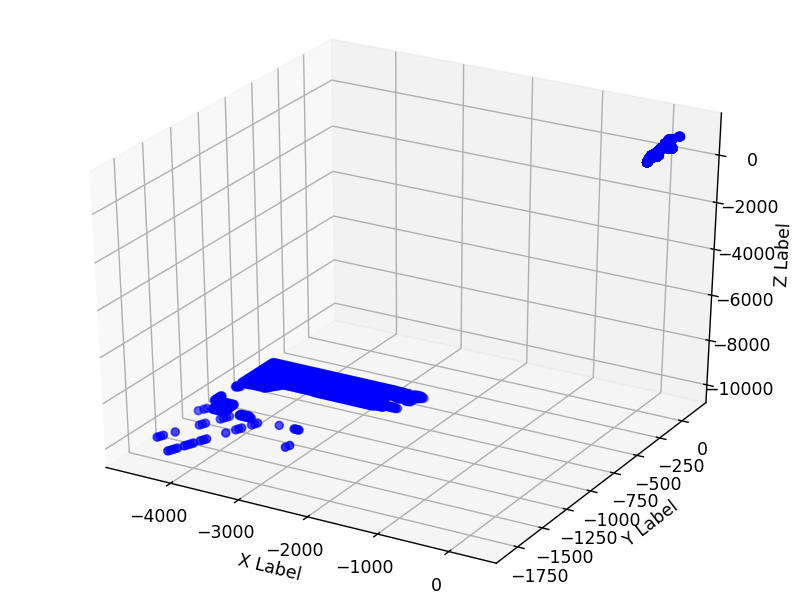

In [33]:
%matplotlib notebook
# transformation to pointcloud form
xs = vecs_p[0, :]
ys = vecs_p[1, :]
zs = vecs_p[2, :]

# visualization
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()

ax = Axes3D(fig) #<-- Note the difference from your original code...
#ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
